# **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Assignment 3: n-gram Language Models, Word Sense disambiguation(LSA using SVD), LSTM**

### **Total points: 100**


# Q1. Latent Semantic Analysis (35 Points) 


 - A. Singular Value Decomposition (SVD) based distributed representation of text and documents. You can use python libraries for matrix decomposition (scipy). To demonstrate your work, use the example dataset (Table 2) of "R. A. Harshman (1990). Indexing by latent semantic analysis. Journal of the American society for information science". (10 Points)

 - B. Visualize (2-D) the documents and terms using library of your choice. (10 Points)

 - C. Implement a function that converts a query string to distributed representation and retrieves relevent documents. Visualize the the results as shown in Fig 1 of the paper. (10 Points)

## <CENTER>Task-1 (10 Points)

### Input data

In [1]:
#Dataset
c1 = 'Human machine interface for Lab ABC computer applications'
c2 = 'A survey of user opinion of computer system response time'
c3 = 'The EPS user interface management system'
c4 = 'System and human system engineering testing of EPS'
c5 = 'Relation of user-perceived response time to error measurement'
m1 = 'The generation of random, binary, unordered trees'
m2 = 'The intersection graph of paths in trees'
m3 = 'Graph minors IV: Widths of trees and well-quasi-ordering'
m4 = 'Graph minors: A survey'
documents = [c1, c2, c3, c4, c5, m1, m2, m3, m4]

### Perform preprocessing of documents

In the below cell remove punctuations and keep only words which belong to nltk corpus

In [2]:
# TASK CELL
# -----

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import words

def preprocess(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        preprocessed_message_list: a list of words containing the processed message. 

    '''     
    
    for m in message:
        if m in string.punctuation:
            message = message.replace(m, ' ') 

    word_list = message.split()
    preprocessed_message_list = []
    
    for w in word_list:
        if w.lower() in words.words():
            preprocessed_message_list.append(w.lower())
        else:
            preprocessed_message_list.append(w)

    return preprocessed_message_list

### Verify preprocessed data

In [3]:
for sent in documents:
    print(preprocess(sent))

['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']


##### Expected Output
```CPP
['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']
```

### Assign names to document names
In the below cell create a list of document names. It will be later used to visualize documents

In [4]:
def createDocName(documents):
    '''
    Input:
        documents: list of documents.
    Output:
        doc_names: a list of document names. 

    '''

    doc_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
    
    return doc_names
    

In [5]:
docName = createDocName(documents)
print(docName)

['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']


##### Expected Output
``` CPP
['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
```

### Words to Index mapping
Retrieve words from documents and create map of word and associate index to it

In [6]:
from nltk.corpus import stopwords

def build_word_to_ix(documents, stopwords=None):
    '''
    Input:
        documents: list of documents
        stopwords: list of stopwords
    Output:
        doc_names: map of words and assoicated index. 

    '''
    word_to_ix = {}
    words = {}
    
    for d in documents:
        message = preprocess(d)
        
        for m in message:
            if m not in stopwords.words('english'):
                if m not in words:
                    words[m] = 0
                else:
                    words[m] += 1
    
    word_list = [k for k,v in words.items() if v>0]

    for i in range(len(word_list)):
        word_to_ix[word_list[i]] = i
                
    
    return word_to_ix

In [7]:
word_to_ix = build_word_to_ix(documents, stopwords)
print(word_to_ix)

{'human': 0, 'interface': 1, 'computer': 2, 'survey': 3, 'user': 4, 'system': 5, 'response': 6, 'time': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}


##### Expected Output
```CPP
{'human': 0, 'interface': 1, 'computer': 2, 'user': 3, 'survey': 4, 'system': 5, 'time': 6, 'response': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}
```

### Document-Terms count matrix

In [8]:
import numpy as np

def build_td_matrix(documents, word_to_ix):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
    Output:
        td_matrix: matrix of count of words in documents, each row 
            represent a word and each column represent a document

    '''
    
    r = len(word_to_ix)
    c = len(documents)

    td_matrix = np.zeros([r,c])

    for i in range(c):
        message = preprocess(documents[i])
        
        for k,v in word_to_ix.items():
            if k in message:
                td_matrix[v][i] += message.count(k)

    return td_matrix

In [9]:
X = build_td_matrix(documents, word_to_ix)
print(X)

[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


##### Expected Output
```CPP
[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 ```

### Singular Value Decomposition
Perform singular value decomposition of count matrix into term singular vector matrix, singular value matrix and document singular vector matrix
- To perform the singular value decompostion please check tutorial:
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [10]:
def svd(documents, word_to_ix, rank):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
        rank: number of colums/rows to retain in decomposed matrix
    Output:
        Uk: term singular vector matrix
        Sk: singular value matrix
        Vk_t: transpose of document singular vector matrix
    '''
 
    M = build_td_matrix(documents, word_to_ix)
    Uk, Sk, Vk_t = np.linalg.svd(M)

    Uk = Uk[:, :rank]
    Sk = np.diag(Sk[:rank])
    Vk_t = Vk_t[:rank].T
    
    return Uk, Sk, Vk_t

In [11]:
Uk, Sk, Vk_t = svd(documents, word_to_ix, 2)
print(Uk)
print(Sk)
print(Vk_t)

[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.20591786  0.27364743]
 [-0.40359886  0.05707026]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]


##### Expected Output
```CPP 
[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.40359886  0.05707026]
 [-0.20591786  0.27364743]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]
 ```

## <CENTER>Task-2 (10 Points)

### Visualize documents in 2D space

[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]


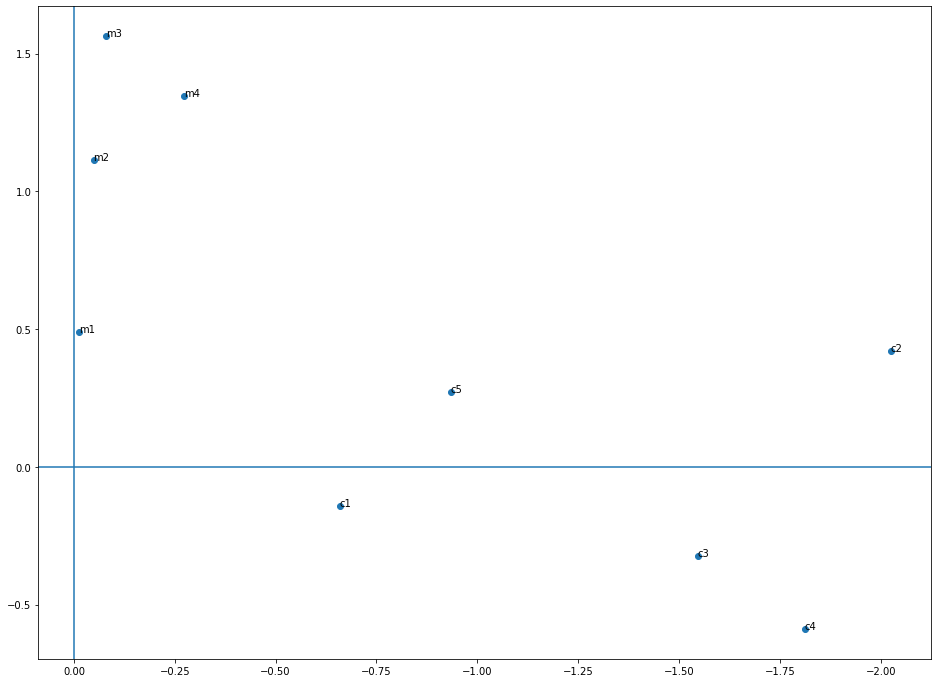

In [12]:
import matplotlib.pyplot as plt

#Visualize documents and print coordinates

doc = Vk_t@Sk
print(doc)

dx = doc[:,0]
dy = doc[:,1]

plt.figure(figsize=(16,12))

plt.scatter(dx, dy)
plt.gca().invert_xaxis()

for i, label in enumerate(docName):
    plt.text(dx[i], dy[i], label)
    
plt.axhline(0, c='tab:blue', ls='-')
plt.axvline(0, c='tab:blue', ls='-')


##### Expected
```CPP
[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]
```
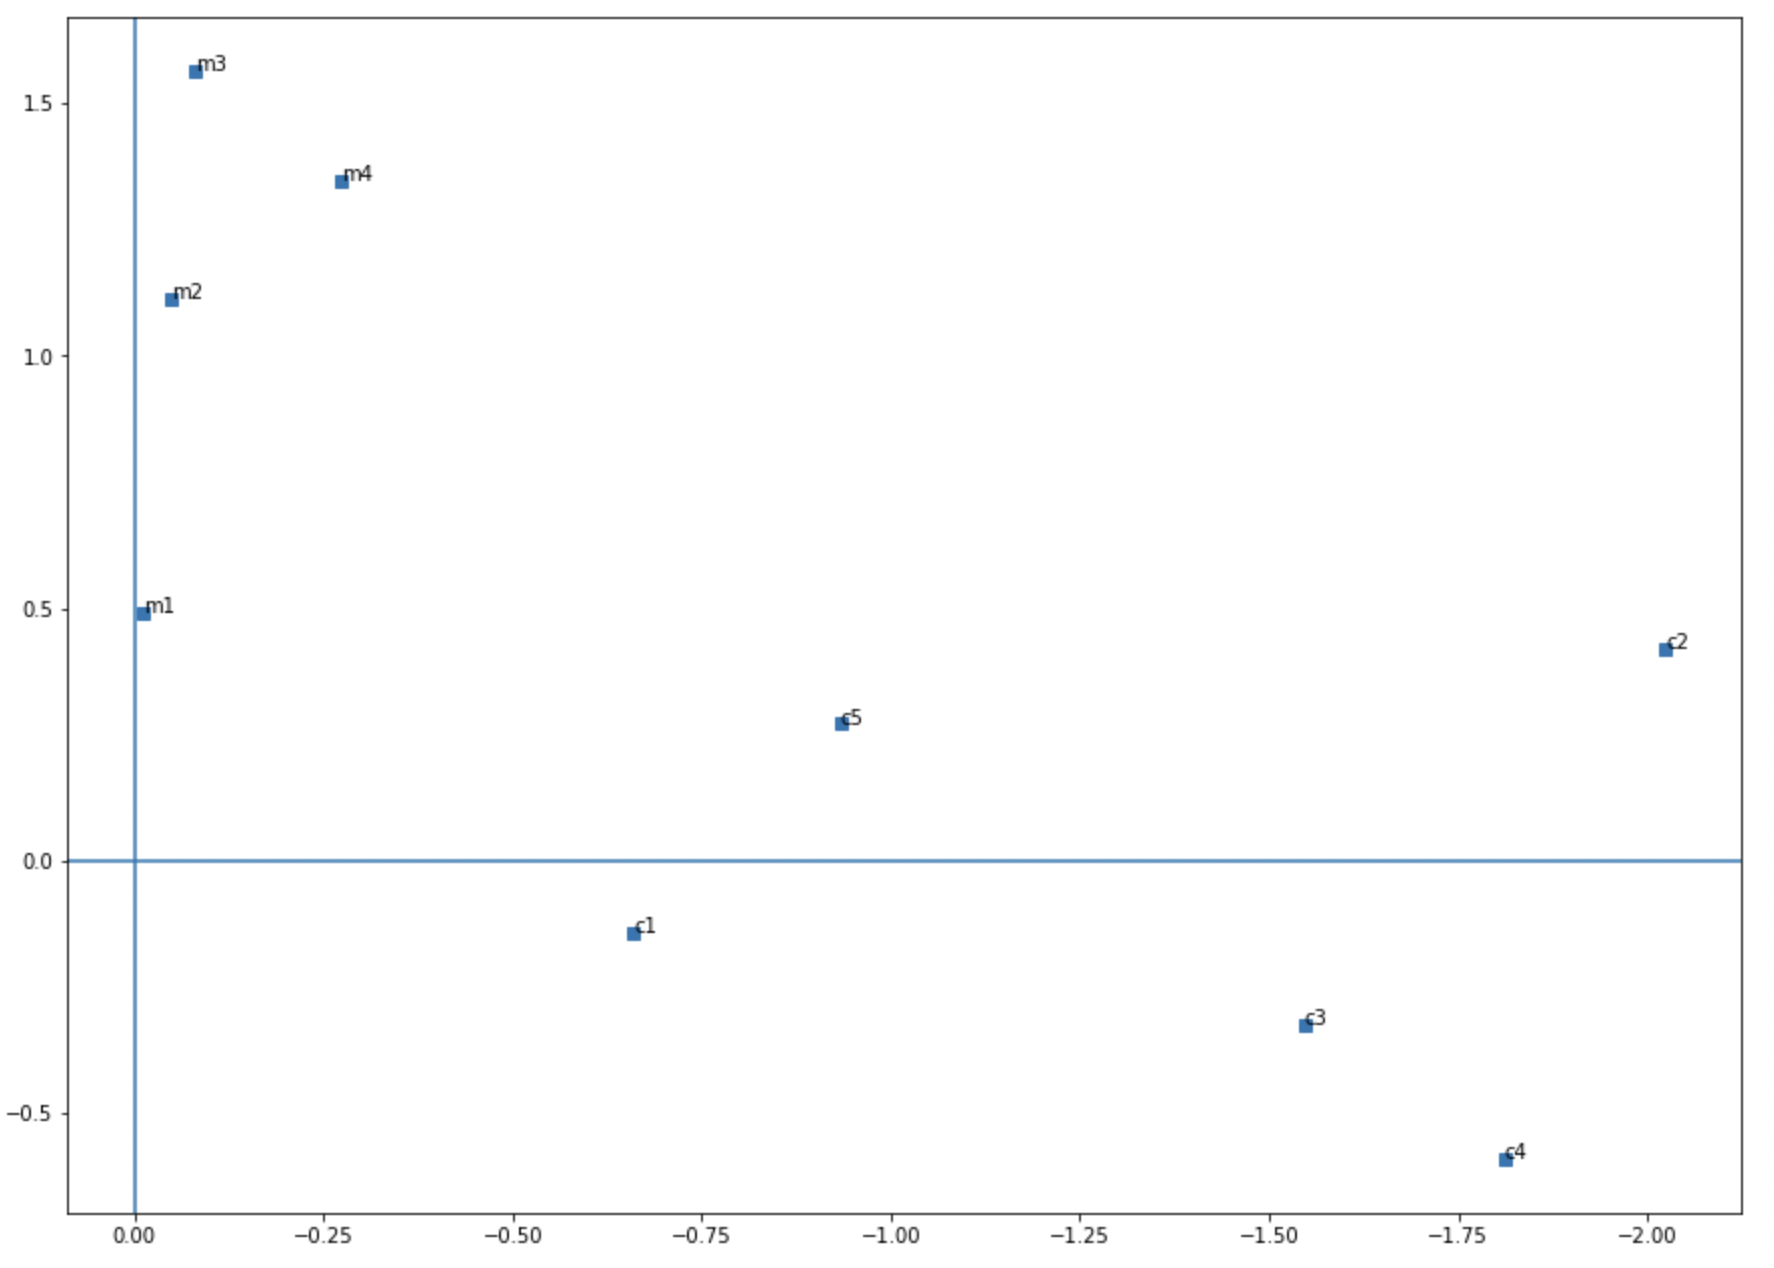

### Visualize terms in 2D space

[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-0.68794764  0.69552995]
 [-1.34837689  0.14505553]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]


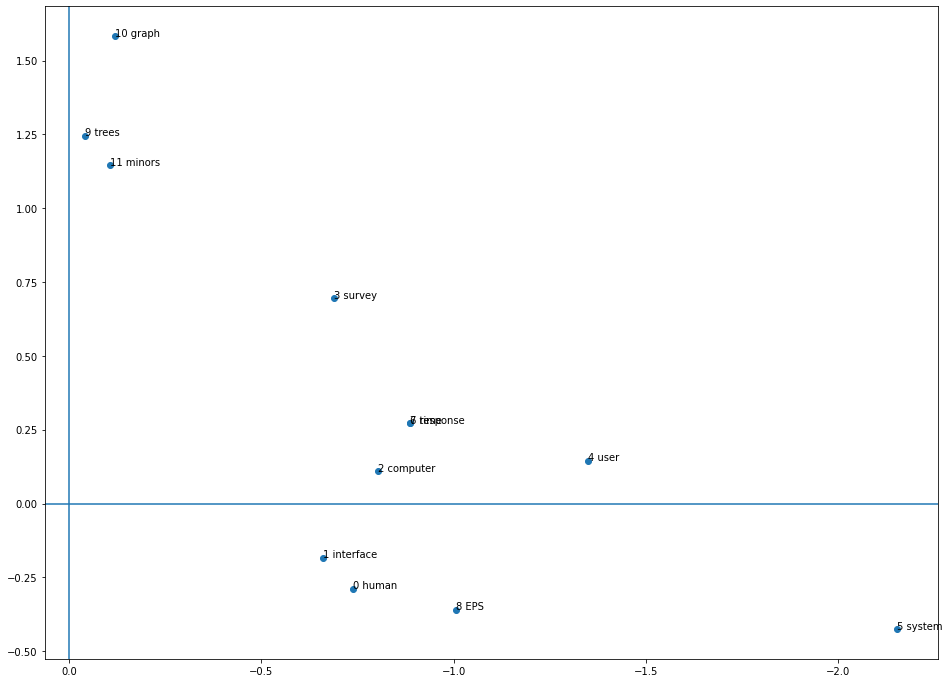

In [13]:
#Visualize terms and print coordinates

terms = Uk@Sk
print(terms)

tx = terms[:,0]
ty = terms[:,1]

plt.figure(figsize=(16,12))

plt.scatter(tx, ty)
plt.gca().invert_xaxis()

for i, label in enumerate(word_to_ix.keys()):
    plt.text(tx[i], ty[i], str(i)+' '+label)
    
plt.axhline(0, c='tab:blue', ls='-')
plt.axvline(0, c='tab:blue', ls='-')

##### Expected
```CPP
[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-1.34837689  0.14505553]
 [-0.68794764  0.69552995]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]
```
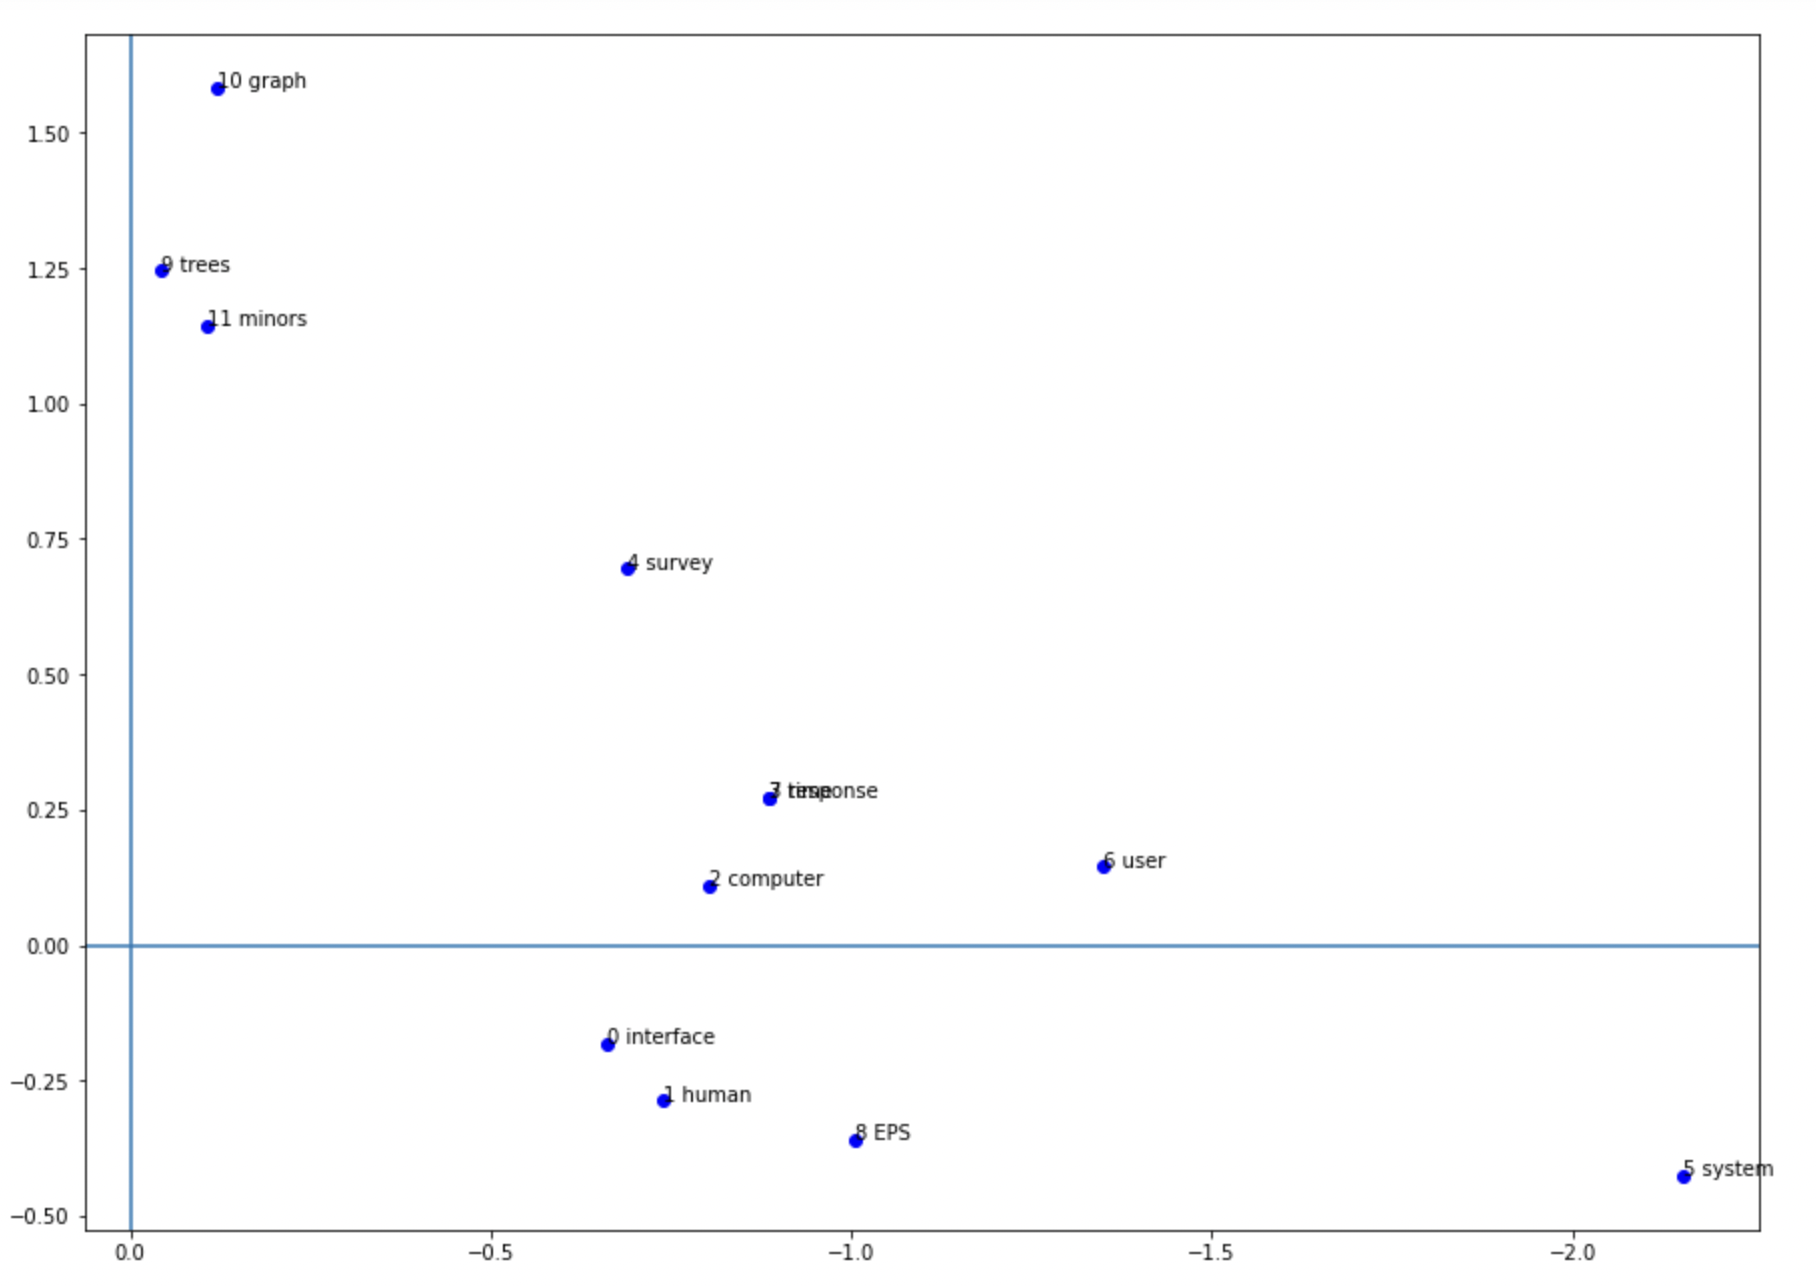

## <CENTER>Task-3 (10 Points)

### Find matching documents for given document

In [14]:
import decimal

# Hint create query vector for input document. Calculate its cosine distance from other documents

def query(s, Uk, Sk, Vk_t, word_to_ix, documents, min_score=0.9):
    '''
    Input:
        s:query document.
        Uk:Term matrix
        Sk:singular value matrix
        Vk_t:Document matrix
        word_to_ix: {word, index} map
        documents:list of document
        min_score:min score beyond which documents are considerd matching
    Output:
        q_hat: coordinates of query vector
        matches: list of tuples containing matching document and its score
    '''

    A = build_td_matrix([s], word_to_ix)
    
    q_hat = A.T@Uk
    doc = Vk_t@Sk
    
    matches = []
    for d in range(len(doc)):        
        doc_norm = np.linalg.norm(doc.T[:,d])
        q_norm = np.linalg.norm(q_hat)

        cos_sim = float((q_hat@doc.T[:,d] /(doc_norm*q_norm)))
        
        if cos_sim > min_score:
            matches.append((documents[d], cos_sim))
  
    return q_hat, matches

In [15]:
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[[-0.461821   -0.07002767]]
[('Human machine interface for Lab ABC computer applications', 0.9980930095689972), ('A survey of user opinion of computer system response time', 0.9374863669686567), ('The EPS user interface management system', 0.998445281334027), ('System and human system engineering testing of EPS', 0.986588640555659), ('Relation of user-perceived response time to error measurement', 0.907559436264429)]


##### Expected
```CPP
[-0.461821   -0.07002767]
[('The EPS user interface management system', 0.9984452813340272), ('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('System and human system engineering testing of EPS', 0.9865886405556598), ('A survey of user opinion of computer system response time', 0.9374863669686595), ('Relation of user-perceived response time to error measurement', 0.9075594362644345)]
```

### Visual representation of query/document

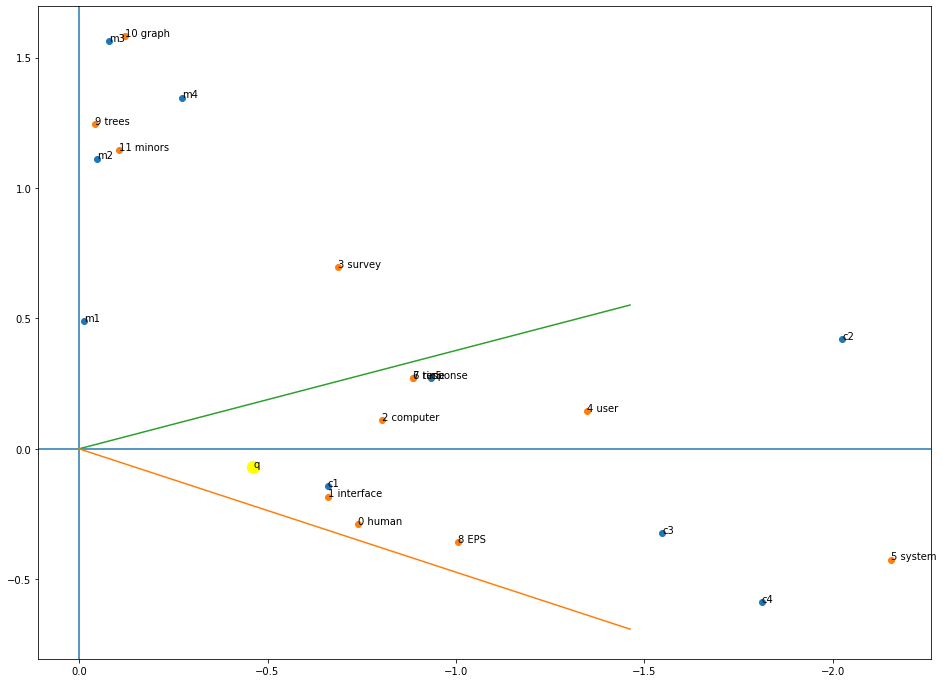

In [16]:
# Plot terms, documents and query documents along with lines representing its cosine angle 
plt.figure(figsize=(16,12))
plt.gca().invert_xaxis()

plt.scatter(q_hat[0][0], q_hat[0][1], c='yellow', s=150)
plt.text(q_hat[0][0], q_hat[0][1], 'q')

plt.scatter(dx, dy)

for i, label in enumerate(docName):
    plt.text(dx[i], dy[i], label)

plt.scatter(tx, ty)

for i, label in enumerate(word_to_ix.keys()):
    plt.text(tx[i], ty[i], str(i)+' '+label)
    
plt.axhline(0, c='tab:blue', ls='-')
plt.axvline(0, c='tab:blue', ls='-')

plt.plot([0, q_hat[0][0] - 1], [0, q_hat[0][1] + np.cos(0.9)], c='tab:green')
plt.plot([0, q_hat[0][0] - 1], [0, q_hat[0][1] - np.cos(0.9)], c='tab:orange')

##### Expected

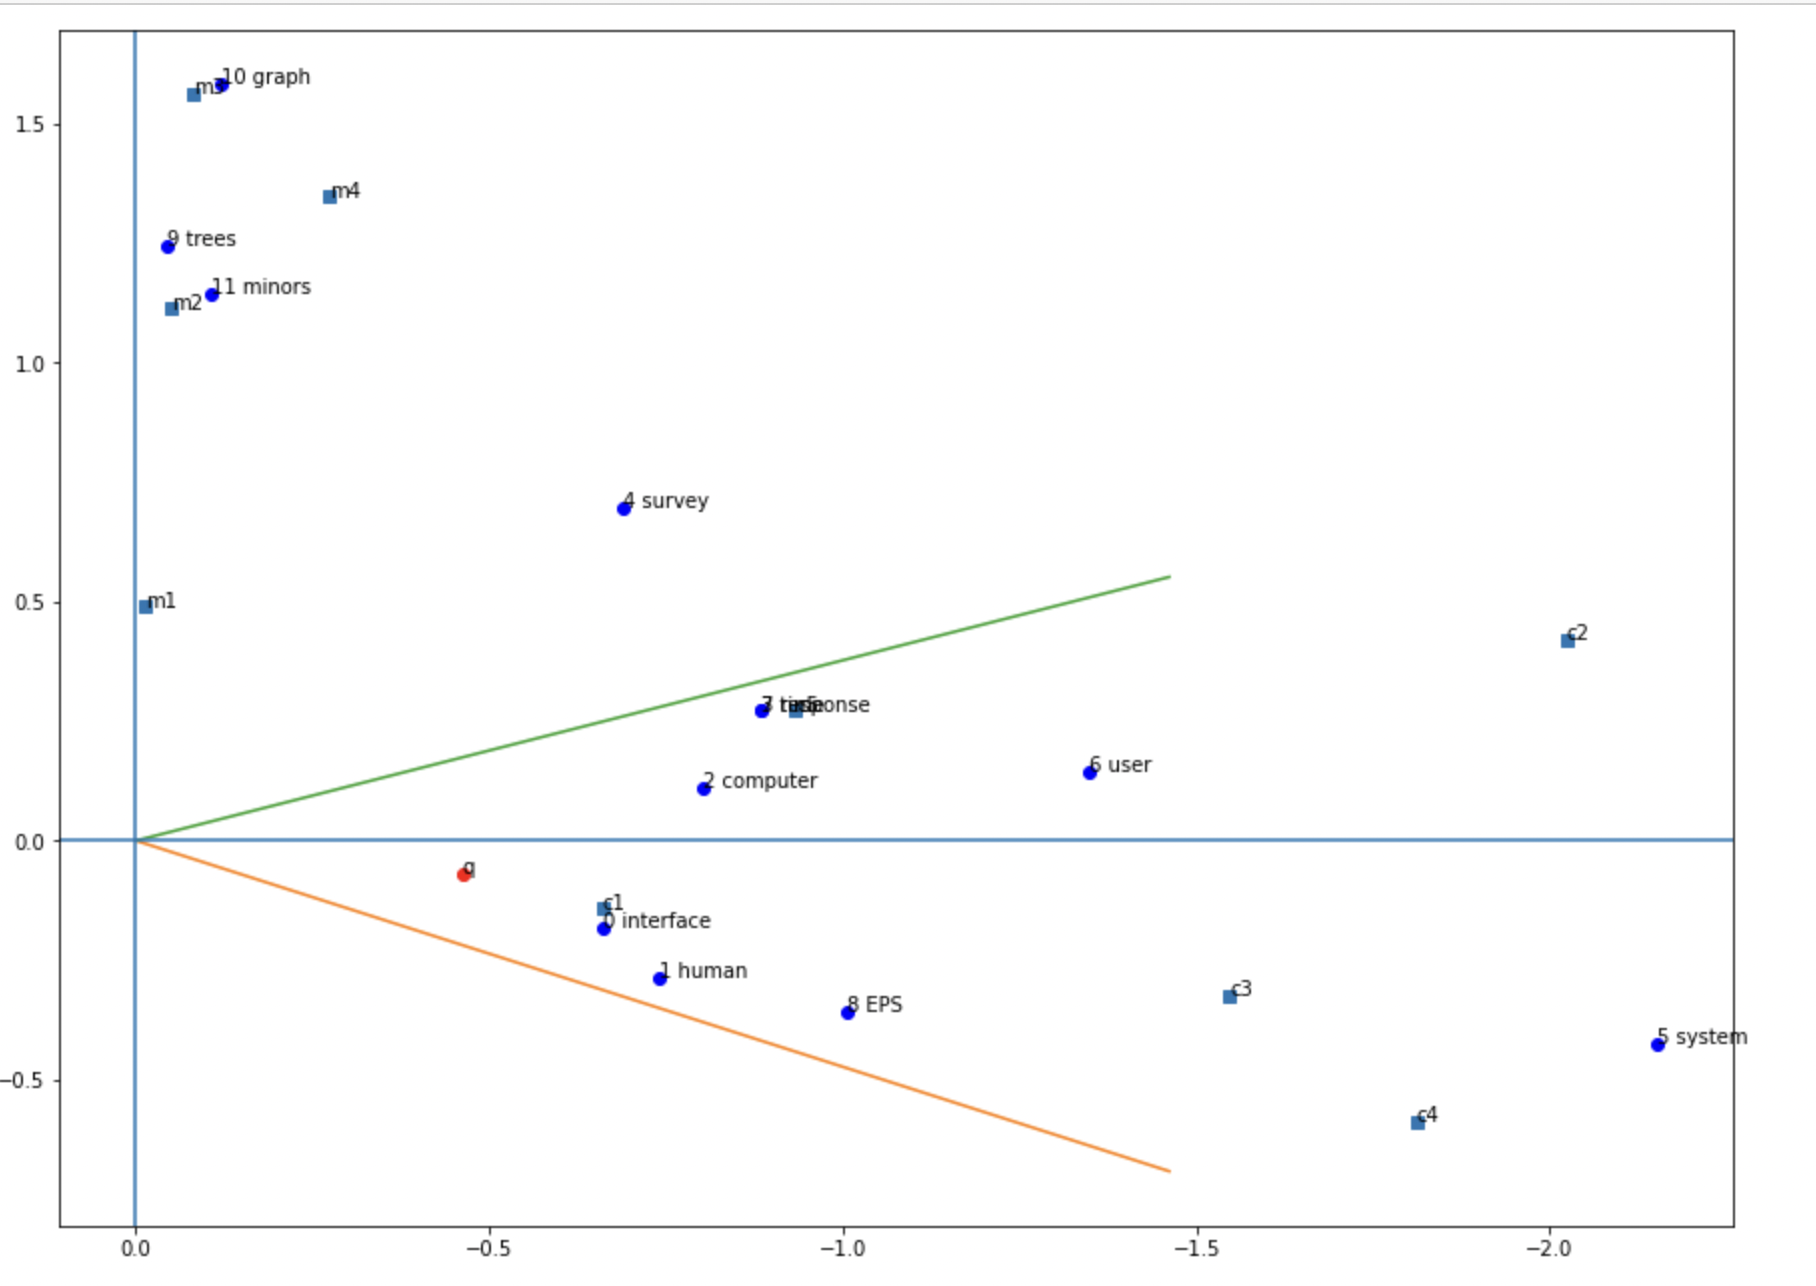


## **Theory questions: (5 points)**
- A) Give short description of Left-eigen vectors, right-eigen vectors and eigen-values matrix retured by Singular Value Decompostion of document-terms count matrix.

- B) Visually represent the document "Graph and tree generation" in 2D space along with words and documents as given in previous question.

A. 

An eigenvector is a special set of vectors associated with a system of linear equations (i.e. matrix equations) and is sometimes referred to as an eigenvector, a proper vector or a potential vector.

A **Right eigenvector** as a column vector X_R satisfies: A * X_R = lambda_R * X_R

A **left eigenvector** as a row vector X_L satisfies: X_L * A = lambda_L * X_L

In many common applications, only the right eigenvector needs to be considered. The unqualified term 'eigenvector' can therefore be understood to refer to the right-hand eigenvector.


A matrix can be thought of as a linear transformation, and the effect of this linear transformation is related to the choice of basis.

Eigenvalue decomposition and Singular Value Decomposition are both about finding a particular set of bases for a matrix (linear transformation). Eigenvalue decomposition finds a set of bases for the eigenvectors, under which the linear transformation has only a scaling effect. The singular value decomposition, on the other hand, finds another set of bases under which the rotation, scaling and projection functions of the linear transform are shown independently.

*   **Eigenvalue decomposition**

    If a non-zero vector v is an eigenvector of a square matrix A, it is necessarily expressed as A*v = λ*v, with λ being the eigenvalue corresponding to the eigenvector v.

    Eigenvalue decomposition is the decomposition of a matrix into the following form. a = Q∑Q^-1 

    where Q is a matrix consisting of the eigenvectors of this matrix A. Σ is a diagonal array where each element on the diagonal is an eigenvalue. A set of eigenvectors of a matrix is a set of orthogonal vectors.

*   **Singular Value Decomposition**

    Suppose M is a matrix of order m × n whose elements all belong to the domain K, i.e. the domain of real numbers or the domain of complex numbers. In this case, there exists a decomposition that

    M_{m×n}=U_{m×m}Σ{m×n}V_{n×n}^T

    where U is a superior matrix of order m × m; Σ is a non-negative real diagonal matrix of order m × n; and VT is a conjugate transpose of V, a superior matrix of order n × n. Such a decomposition is known as the singular value decomposition of M. In this way, Σ can be uniquely determined by M.

    The columns of V form a set of orthogonal "input" or "analytic" basis vectors for M . These vectors are the eigenvectors of M∗M.
    The columns of U form a set of orthogonal "output" basis vectors of M. These vectors are the eigenvectors of MM∗.
    The elements on the diagonal of Σ are singular values and can be thought of as 'extended controls' for the scalars between the inputs and outputs. These are the non-negative square roots of the eigenvalues of MM∗ and M∗M, corresponding to the row vectors of U and V.










In [17]:
# B.

q_hat, matches = query('Graph and tree generation', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[[-0.03613585  0.62278523]]
[('The generation of random, binary, unordered trees', 0.9994893286320654), ('The intersection graph of paths in trees', 0.9999010903647539), ('Graph minors IV: Widths of trees and well-quasi-ordering', 0.9999793491388691), ('Graph minors: A survey', 0.9898509606948506)]


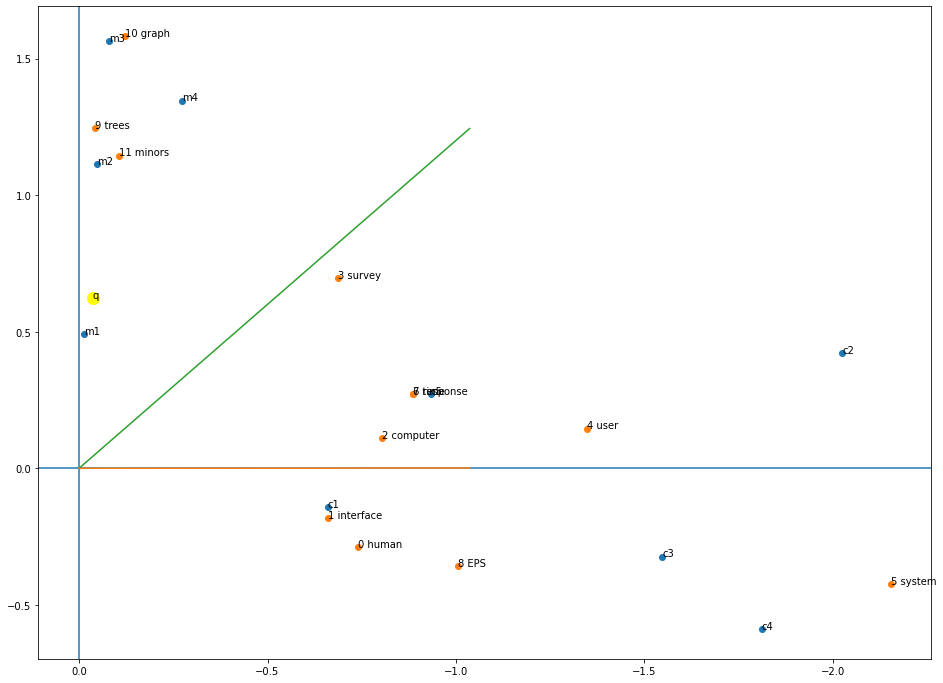

In [18]:
# Plot terms, documents and query documents along with lines representing its cosine angle 
plt.figure(figsize=(16,12))
plt.gca().invert_xaxis()

plt.scatter(q_hat[0][0], q_hat[0][1], c='yellow', s=150)
plt.text(q_hat[0][0], q_hat[0][1], 'q')

plt.scatter(dx, dy)

for i, label in enumerate(docName):
    plt.text(dx[i], dy[i], label)

plt.scatter(tx, ty)

for i, label in enumerate(word_to_ix.keys()):
    plt.text(tx[i], ty[i], str(i)+' '+label)
    
plt.axhline(0, c='tab:blue', ls='-')
plt.axvline(0, c='tab:blue', ls='-')

plt.plot([0, q_hat[0][0] - 1], [0, q_hat[0][1] + np.cos(0.9)], c='tab:green')
plt.plot([0, q_hat[0][0] - 1], [0, q_hat[0][1] - np.cos(0.9)], c='tab:orange')

# Q2. n-Gram Language Models

Your task is to train n-gram language models. [Ref SLP Chapter 3]

- Task 1: You will train unigram, bigram, and trigram models on given training files. Then you will score on given test files for unigram, bigram, and trigram. you will generate sentences from the trained model and compute perplexity.
- Task 2: You will create training data for n > 3. and Repeat the above task from training model.
<h6>Part-A = (55 Points) </h6>

In [19]:
'''
Your imports go here
You are encouraged to implement your own functions and not use from library.
'''
import sys
from collections import Counter
import numpy as np

In [20]:
# constants to define pseudo-word tokens
# access via UNK, for instance
# for this assignemnt we will follow <s> tag for beginning of sentence and
# </s> for end of senetence as suggested in SLP Book. Check sample training files for reference.
UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"

We need to initialise global variables for model

In [21]:

"""Initializes Parameters:
  n_gram (int): the n-gram order.
  is_laplace_smoothing (bool): whether or not to use Laplace smoothing
  threshold: words with frequency  below threshold will be converted to token
"""
# Initializing different object attributes
n_gram = None
is_laplace_smoothing = True
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = None
threshold = 1


### Implement training function (10 points)

In [22]:
train_path = "sample_data/berp-training-seven.txt"
test_path = "sample_data/hw2-test-seven.txt"

In [23]:
# from nltk import ngrams
import string

def make_ngrams(tokens: list, n: int) -> list:
    """Creates n-grams for the given token sequence.
    Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create

    Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
    """
    n_grams = []
    
#     tokens = tokens.lower()
    
    for t in tokens:
        if t in string.punctuation:
            tokens = tokens.replace(t, ' ') 
    
    n_grams = list(zip(*[tokens[i:] for i in range(n)]))
    
    return n_grams

In [24]:
def train(training_file_path):
    """Trains the language model on the given data. Input file that
    has tokens that are white-space separated, has one sentence per line, and
    that the sentences begin with <s> and end with </s>
    Parameters:
      training_file_path (str): the location of the training data to read

    Returns:
    N Gram Counts, Vocab, N Minus 1 Gram Counts
    """
    with open(training_file_path, 'r') as fh:
        content = fh.read().split() # Read and split data to get list of words
    
    # Get the count of each word
    cnt = Counter()
    for word in content:
        cnt[word] += 1
    
    # Replace the words with <UNK> if count is < threshold(=1)
    content = [UNK if cnt[w] <= 1 else w for w in content]
    
    # count n
    sentence = []
    for w in content:
        if w != '</s>':
            sentence.append(w)
        else:
            break
    n = sentence.count('<s>')+1
    
    # make use of make_n_grams function
    n_grams = make_ngrams(content, n)
    n_gram_counts = dict(Counter(n_grams))
    
    # Get the training data vocabulary
    vocab = list(set(content))
    
    # For n>1 grams compute n-1 gram counts to compute probability
    if n > 1:
        n_minus_1_gram = make_ngrams(content, n-1)
        n_minus_1_gram_counts = dict(Counter(n_minus_1_gram))
    
    return n_gram_counts, vocab, n_minus_1_gram_counts

Output your Trained Data Parameters:

In [25]:
n_gram_counts, vocab, n_minus_1_gram_counts = train(train_path)
print(n_gram_counts)
print(vocab)

{('<s>', '<s>', '<s>', '<s>', '<s>', '<s>', "let's"): 196, ('<s>', '<s>', '<s>', '<s>', '<s>', "let's", 'start'): 163, ('<s>', '<s>', '<s>', '<s>', "let's", 'start', 'over'): 131, ('<s>', '<s>', '<s>', "let's", 'start', 'over', '</s>'): 120, ('<s>', '<s>', "let's", 'start', 'over', '</s>', '</s>'): 120, ('<s>', "let's", 'start', 'over', '</s>', '</s>', '</s>'): 120, ("let's", 'start', 'over', '</s>', '</s>', '</s>', '</s>'): 124, ('start', 'over', '</s>', '</s>', '</s>', '</s>', '</s>'): 366, ('over', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>'): 367, ('</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '<s>'): 6755, ('</s>', '</s>', '</s>', '</s>', '</s>', '<s>', '<s>'): 6755, ('</s>', '</s>', '</s>', '</s>', '<s>', '<s>', '<s>'): 6755, ('</s>', '</s>', '</s>', '<s>', '<s>', '<s>', '<s>'): 6755, ('</s>', '</s>', '<s>', '<s>', '<s>', '<s>', '<s>'): 6755, ('</s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>'): 6755, ('<s>', '<s>', '<s>', '<s>', '<s>', '<s>', 'my'): 6, ('<s>', '<s>', '<s>', '

In [26]:
print("vocab:", len(vocab))
print("n_minus_1_gram_counts:", len(n_minus_1_gram_counts))
print("n_gram_counts:", len(n_gram_counts))

vocab: 923
n_minus_1_gram_counts: 36457
n_gram_counts: 41897


### Scoring function (points 5):
Implement Score function that will take input sentence and output probability of given string representing a single sentence.

In [27]:
def score(sentence):
    """Calculates the probability score for a given string representing a single sentence.
    Parameters:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
      
    Returns:
      float: the probability value of the given string for this model
    """
    
    # count n
    content = []
    for w in sentence.split():
        if w != '</s>':
            content.append(w)
        else:
            break
            
    n = content.count('<s>')+1
    
    # Split the input sentence and replace out of vocabulary tokens with <UNK>   
    words = sentence.split()
    words = [UNK if w not in vocab else w for w in words]
    
    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability
    ng_words =  make_ngrams(words, n)
    
    probablity = 1
    for w in ng_words:
        ng = n_gram_counts.get(w, 0)
        ng_1 = n_minus_1_gram_counts.get(w[:-1], 0)
        
        p = (ng + 1)/(ng_1 + len(vocab))
        probablity *= p
    
    return probablity

In [28]:
with open(test_path, 'r') as fh:
    test_content = fh.read().split("\n")
num_sentences_1 = len(test_content)
ten_sentences_1 = test_content[:10]
print("# of test sentences: ", num_sentences_1)
probablities = []

# of test sentences:  100


In [29]:
# print probabilities/score of sentences in test content
for sentence in test_content:
    probablities.append(score(sentence))
probablities = np.array(probablities)
mean = np.mean(probablities)
std_dev = np.std(probablities)

In [30]:
print(probablities)
print(mean, std_dev)

[9.49527548e-23 1.03367961e-22 3.02431915e-35 2.64072951e-29
 3.78183723e-37 1.75695865e-27 2.82063511e-29 2.22180623e-42
 2.52536425e-35 5.60166596e-15 4.07633271e-24 1.30708957e-25
 4.03447355e-27 1.64331442e-14 1.42155337e-28 5.08366992e-16
 4.45571252e-17 9.53681541e-18 5.94336116e-32 2.78354351e-36
 7.51368907e-58 3.55663371e-51 2.74316159e-37 5.38796960e-33
 4.17795339e-32 1.48808372e-25 7.18734177e-18 1.55599826e-24
 8.89977985e-38 1.65511518e-28 1.59065878e-22 1.21465842e-34
 1.28888371e-29 2.84454908e-27 3.51159705e-35 3.94151960e-33
 8.16647293e-19 9.33673322e-21 1.16856540e-29 4.50880393e-25
 6.09367474e-29 8.20101805e-28 1.75918745e-25 1.40880379e-32
 2.71841677e-31 3.07949946e-30 2.06301152e-25 1.70692850e-25
 2.82981393e-34 1.13802759e-36 7.35426044e-38 3.21717114e-29
 3.23644417e-13 6.84700895e-09 6.84700895e-09 2.01514607e-28
 2.06828351e-29 1.45890325e-19 3.72134306e-16 1.64113080e-34
 7.33512494e-07 3.00416554e-28 2.04848965e-34 7.54812342e-25
 1.82798532e-44 4.821432

### Sentence generation (10 points)
Generate sentence from the above trained model
- To generate next word from a set of probable n-grams and their probabilities check below tutorial:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [31]:
def generate_sentence():
    """Generates a single sentence from a trained language model using the Shannon technique.
      
    Returns:
      str: the generated sentence
    """
    # Start with <s> and randomly generate words until we encounter sentence end
    n = len(next(iter(n_gram_counts)))
    last_words = ['<s>'] *(n-1)
    
    # Append sentence begin markers for n>2
    sentence = list(last_words)
    
    # Keep track of previous word for stop condition
    prev_word = '<s>'
    
    if n > 1:
        while prev_word != "</s>":
            
            # Construct the (n-1) gram so far
            new_ng = {k:v for k, v in n_gram_counts.items() if k[:-1] == tuple(last_words)} 
        
            # Get the counts of all available choices based on n-1 gram
            choices = [k[-1] for k in new_ng.keys()] 
        
            # Convert the counts into probability for random.choice() function
            probs = []
            for w in new_ng:
                ng = n_gram_counts.get(w, 0)
                ng_1 = n_minus_1_gram_counts.get(w[:-1], 0)

                p = (ng + 1)/(ng_1 + len(vocab))
                probs.append(p)
        
            next_word = np.random.choice(choices, p = np.array(probs)/sum(probs))
        
            # If <s> is generated, ignore and generate another word  
            while next_word == '<s>':
                next_word = np.random.choice(choices, p = np.array(probs)/sum(probs))

            sentence += [next_word]
            last_words = sentence[-(n-1):]
            prev_word = next_word
        
    else:
      # In case of unigram model, n-1 gram is just the previous word and possible choice is whole vocabulary
      while prev_word != "</s>":
            
        # Convert the counts into probability for random.choice() function
        next_word = np.random.choice(vocab)

        # If <s> is generated, ignore and generate another word
        while next_word == '<s>':
            next_word = np.random.choice(vocab)

        sentence += [next_word]
        
    # Append sentence end markers for n>2
    sentence = ' '.join(sentence + ['</s>'] *(n-2))
    
    return sentence

In [32]:
def generate(n):
    """Generates n sentences from a trained language model using the Shannon technique.
    Parameters:
      n (int): the number of sentences to generate
      
    Returns:
      list: a list containing strings, one per generated sentence
    """
    # Generate sentences one by one and store
    sentences = []
    for i in range(n):
        sentences.append(generate_sentence())
    
    return sentences

In [33]:
sentences = generate(50)
print("Sentences:")
for sentence in sentences:
    print(sentence)

Sentences:
<s> <s> <s> <s> <s> <s> i want mexican food for lunch </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> do you have any restaurant in your <UNK> which serves german food </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> let's start over </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> <UNK> about spanish restaurants </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> may i see the last list of restaurants again please </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> <UNK> delicatessen food </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> oh what day what is the question </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> i would like to see the list of pizza restaurants again </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> start over </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> i'd like to eat indian food </s> </s> </s> </s> </s> </s>
<s> <s> <s> <s> <s> <s> may i see the last list of restaurants again please </s> </s> </s> </s> </s>

### Evaluate model perplexity (5 points)
Measures the perplexity for the test sequence with your trained model. 
you may assume that this sequence may consist of many sentences "glued together"

The perplexity of the given sequence is the inverse probability of the test set, normalized by the number of words.


In [34]:
# Since this sequence will cross many sentence boundaries, we need to include 
# the begin- and end-sentence markers <s> and </s> in the probability computation. 
# We also need to include the end-of-sentence marker </s> 
# but not the beginning-of-sentence marker <s>) in the total count of word tokens N

def perplexity(test_sequence):
    """.
    Parameters:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity of

    Returns:
      float: the perplexity of the given sequence
    """ 

    # Replace out of vocab words with <UNK>, already done in score function
    # test_sequence = [token if token in vocab else UNK for token in test_sequence.split()]
    
    # Remove sentence begin markers from data for computing N
    seq = test_sequence.replace('<s>', '')
    N = len(seq.split())

    # Get the probability for the sequence
    p = score(test_sequence)
    perplexity = (1/p)**(1/N)
    
    return perplexity

In [35]:
print(perplexity(" ".join(sentences[0:10])))

100.69703000809533


In [36]:
print(perplexity(" ".join(test_content[0:10])))

300.2105522096302


### **Explore and explain: (5 points)**
* Experiment n_gram model for n = [1,2,3..7] of your choice. Explain the best choice of n that generates more meaninful sentences.


In [60]:
# Create training data with different n
# with open("test_data/hw2-test_bi.txt", 'r') as fh:

with open("sample_data/berp-training-seven.txt",'w') as ff:
    with open('sample_data/berp-training-six.txt','r') as f:   
        line = f.readlines()   
        for l in line:
            l = l.strip("\n")
            new_l = "<s> " + l + "</s> \n"
            ff.write(new_l) 


Based on the experimental data obtained below and the sample sentences generated, it seems to me that when n
=3/4 the sentences generated are more meaningful and have less n. 

Actually, as n increases, the proportion of meaningful sentences generated did increases, but the increase is not very large or almost the same.

Results:

uni: 
    sentences = 44.86763268271512
    test_content = 72.82591535667639

    <s> we have some thai house cafe vin </s>
    <s> i would like uh like to spend seven hundred dollars per head </s>
    <s> i'm interested in indian food to eat dinner </s>
    <s> i am <UNK> telephone number for a cheap ones have breakfast before seven and i want some more information do you show me mcdonald's </s>
    <s> no more far from icsi about cafe </s>
    
bi: 
    sentences = 65.74236924601627
    test_content = 72.82591535667639

    <s> can you know about le cheval restaurant </s>
    <s> and salad </s>
    <s> i would like to spend much does musical offering </s>
    <s> i want to know something not more information of cuban instead of expensive restaurant should be cheap </s>
    <s> it should cost would like to eat thai barbecue restaurant </s>


tri: 
    sentences = 124.60264473685633
    test_content = 132.46094460783402

    <s> <s> i have a car so i think that can be quite far from icksee should be lunch </s> </s>
    <s> <s> i'd like to have names of some italian food for wednesday night of the restaurants around here </s> </s>
    <s> <s> what is your favorite restaurant </s> </s>
    <s> <s> i would like some mexican place </s> </s>
    <s> <s> give me information about la-mediterranee la-mediterranee something like that </s> </s>

    
four: 
    sentences = 154.17502438133727
    test_content = 199.30173864324465

    <s> <s> <s> i would like to eat this evening </s> </s> </s>
    <s> <s> <s> uh what i really meant is that i want food from vietnam </s> </s> </s>
    <s> <s> <s> okay let's go back to italian food now </s> </s> </s>
    <s> <s> <s> i would like to eat french cuisine or california cuisine or something like that </s> </s> </s>
    <s> <s> <s> do you have hungarian food </s> </s> </s>

    
five: 
    sentences = 97.92686650963635
    test_content = 240.27018199252265

    <s> <s> <s> <s> which thai restaurants serve lunch in berkeley </s> </s> </s> </s>
    <s> <s> <s> <s> what californian food do you have any vietnamese restaurants in your database </s> </s> </s> </s>
    <s> <s> <s> <s> okay go back to the list of thai restaurants you gave me before </s> </s> </s> </s>
    <s> <s> <s> <s> tell me more about mel's diner </s> </s> </s> </s>
    <s> <s> <s> <s> i'm not very hungry and i would like the restaurant to be within two miles of icsi </s> </s> </s> </s>

    
six: 
    sentences = 149.2874485556271
    test_content = 272.51532712927747

    <s> <s> <s> <s> <s> it's still thai food and it cost can cost even more </s> </s> </s> </s> </s>
    <s> <s> <s> <s> <s> i want expensive italian food </s> </s> </s> </s> </s>
    <s> <s> <s> <s> <s> i'm not willing to travel more than fifteen </s> </s> </s> </s> </s>
    <s> <s> <s> <s> <s> i want to travel up to three kilometers </s> </s> </s> </s> </s>
    <s> <s> <s> <s> <s> with california cuisine </s> </s> </s> </s> </s>
    
seven: 
    sentences = 177.73812285760332
    test_content = 300.2105522096302

    <s> <s> <s> <s> <s> <s> for this same case it needs to be sunday night </s> </s> </s> </s> </s> </s>
    <s> <s> <s> <s> <s> <s> i would like to go to cafe de <UNK> </s> </s> </s> </s> </s> </s>
    <s> <s> <s> <s> <s> <s> what i really meant is that i want to go to a cheap restaurant </s> </s> </s> </s> </s> </s>
    <s> <s> <s> <s> <s> <s> go back to the chinese restaurant list please </s> </s> </s> </s> </s> </s>
    <s> <s> <s> <s> <s> <s> okay this isn't the one i was looking for give me a mcdonald's </s> </s> </s> </s> </s> </s>



# Q3. Classification using LSTM - using Tensorflow (30 Points)
In this part, we will be building a bidirectional LSTM network to train and inference sentiment analysis on IMDB dataset.<br>

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time to tweak your hyperparameters.
- Without a GPU, You might have to wait longer to experiment.

### Library Imports

In [38]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



### Visualizing data distribution (1 Point)


In [39]:
gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name)

/device:GPU:0


In [40]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [45]:
!ls

sample_data


In [48]:
## Reading the data and removing columns that are not important. 
dataset = pd.read_csv("./sample_data/movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [49]:
#######################################################   
# print head of data frame with help of head function # 
#######################################################

dataset.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Petter Mattei's "Love in the Time of Money" is...  positive
4  Probably my all-time favorite movie, a story o...  positive

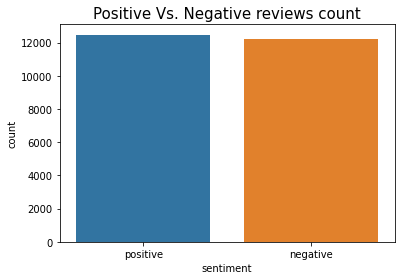

In [50]:
 ####################################################### 
 # plot Positive Vs. Negative reviews count            # 
 #######################################################

sns.countplot(x = "sentiment", data = dataset)

plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()



### Cleaning the Reviews (2 Points)

In [51]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [52]:
#############################################################################################  
# Clean all the reviews in the dataset using the clean_text function provided above         # 
############################################################################################# 
 
dataset['review'] = dataset['review'].apply(clean_text)


In [53]:
#####################################################################
# print head of the "CLEANED" data frame with help of head function # 
#####################################################################
 
dataset.head()

review sentiment
0  one reviewer mentioned watching 1 oz episode y...  positive
1  wonderful little production br br filming tech...  positive
2  thought wonderful way spend time hot summer we...  positive
3  petter matteis love time money visually stunni...  positive
4  probably alltime favorite movie story selfless...  positive

### Splitting the dataset and Encoding Labels (2 Points)

Spliting data: <br> 
80% for the training and the remaining 20% for validation.

Encoding Labels: <br>
Encode labels as negative and positive as 0 and 1 respectively


In [54]:
#################################################################################
# Split the data using the sklearn module                                       #
# 80% for the training and the remaining 20% for validation                     #
#################################################################################
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.2)


In [55]:
#################################################################################
# Initialize label encoder from sklearn module                                  #
# fit on train labels and transform both train and validation labels            #
#################################################################################
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

train_labels = [d[1] for d in train_data.values]
val_labels = [d[1] for d in val_data.values]

le.fit(train_labels)

train_le = le.transform(train_labels)
val_le = le.transform(val_labels)

### Pre-Processing The Text (5 Points)
 

In [56]:
# You can use the modules given below
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

###############################################################################  
# Fit your tokenizer on the training reviews                                  #
###############################################################################
Tok = Tokenizer()
Tok.fit_on_texts(list(train_data['review']))

#################################################################################################
# The word_index dictionary assigns a unique index to each unique word present in the training  #
# reviews.                                                                                      #
#                                                                                               #
# Create the word_index dictionary using the tokenizer                                          #
# Find the vocabulary of your training reviews                                                  #
#################################################################################################

# word_index = {}
# vocabulary = None

word_index = Tok.word_index
vocabulary =list(word_index.keys())

#################################################################################################
# Convert the reviews in the dataset to their index form by using a function available          #
# with the tokenizer                                                                            #
# HINT : convert training and validation reviews into sequences                                 #
#################################################################################################

train_seq = Tok.texts_to_sequences(list(train_data['review']))
val_seq = Tok.texts_to_sequences(list(val_data['review']))

#################################################################################################
# Pad the the training and validation sequences so all of them have the same length             # 
# set maxlen = 200                                                                              #
#################################################################################################

# maxlen which is the maximum length of one review we will use for our training
train_pad = pad_sequences(train_seq, maxlen=200, padding='post')
val_pad = pad_sequences(val_seq, maxlen=200, padding='post')

print('Vocabulary : {}'.format(vocabulary))

Vocabulary : ['br', 'movie', 'film', 'one', 'like', 'time', 'good', 'character', 'get', 'would', 'story', 'even', 'make', 'see', 'really', 'scene', 'well', 'much', 'people', 'also', 'great', 'bad', 'show', 'first', 'dont', 'way', 'thing', 'made', 'think', 'could', 'life', 'go', 'know', 'watch', 'many', 'love', 'two', 'seen', 'never', 'actor', 'plot', 'say', 'acting', 'look', 'best', 'little', 'year', 'end', 'ever', 'take', 'better', 'still', 'man', 'come', 'work', 'part', 'something', 'find', 'lot', 'give', 'want', 'im', 'director', 'real', 'watching', 'back', 'performance', 'guy', 'doesnt', 'play', 'though', 'woman', 'didnt', 'another', 'actually', 'nothing', 'funny', 'new', 'going', 'every', 'role', 'u', 'old', 'point', 'thats', 'feel', 'quite', 'girl', 'cant', 'day', 'cast', 'pretty', 'world', 'seems', 'minute', 'fact', 'young', 'thought', 'got', 'comedy', 'however', 'horror', 'big', 'around', 'enough', 'right', 'may', 'action', 'friend', 'ive', 'bit', 'without', 'star', 'always', '

### Using glove vectors for embedding (5 Points)

GloVe vectors capture both global statistics and local statistics of a corpus. We use GloVe to convert words to embeddings in the vector space based on their semantics. 

We will be using the 200-dimensional GloVe vectors for the task at hand.

To learn more about GloVe please read the following resource:
- https://nlp.stanford.edu/pubs/glove.pdf

In [63]:
glove_dictionary = {}
with open('./sample_data/glove.6B.200d.txt', encoding='UTF-8') as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [64]:
 # All the words which are not in the GloVe dictionary will be assigned a zero vector.

embedding_matrix = np.zeros((len(vocabulary)+1, 200))

######################################################################
# The glove_dictionary contains words vs their respective embeddings #
#                                                                    #
# Create the embedding matrix using the glove_dictionary             #
######################################################################

for w, i in word_index.items():
    emb_vec = glove_dictionary.get(w)
    
    if not emb_vec is None:
        embedding_matrix[i] = emb_vec


In [65]:
embedding_matrix.shape

(99767, 200)

Sample output : (99987, 200)

### Creating The Model (10)

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time.
- Without a GPU, You might have to wait longer to experiment.


Useful resources : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout <br>





In [66]:
import tensorflow as tf

tf.random.set_seed(42)

######################################################
# Complete this linear model in tensorflow           #
######################################################

def build_model(embedding_matrix):

    ''' 
    Arguments:
    embedding_matrix : a matrix with the corresponding embeddings
    of all words.

    Returns:
    The LSTM model that you created.
    '''
  
    model = tf.keras.Sequential()
    model.add(tf.keras.Input((embedding_matrix.shape[1], )))

    # TO DO: layer 1 : add embedding layer
    # The embedding layer maps the words to their embedding vectors from the embedding matrix
    
    model.add(tf.keras.layers.Embedding(input_dim=len(vocabulary)+1, output_dim=200, 
                                         input_length=200, weights = [embedding_matrix],  trainable=False))

    # TO DO: layer 2 : add Bidirectional LSTM Layer 
    model.add(tf.keras.layers.LSTM(128, return_sequences=True))

    # TO DO Add more layers : you can add more dense layers and dropout
    # NOTE : You should be able to achieve an validation accuracy greater than 85%
    #        within 10 epochs
    # model.add(tf.keras.layers.Dropout(0.5))
    # model.add(tf.keras.layers.LSTM(128, return_sequences=True))

    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(128))

    # TO DO Final layer : add output layer and activation 
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # TO DO : use a loss function, optimizer as adam to compile 
    # and evaluate model on auc,precision,recall,accuracy
    # HINT : choose your loss function based on the task (binary classification)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['AUC', 'Precision', 'Recall', 'accuracy'])         
    

    return model

In [67]:
# NOTE : You should be able to achieve an validation accuracy greater than 85%
#        within 10 epochs

#################################################################
# Call the build_model function and initialize the model        #
#################################################################

model = build_model(embedding_matrix)

history = model.fit(
    train_pad,
    train_le,
    batch_size=32,
    epochs=10,
    validation_data=(val_pad, val_le),
)

#######################################################################################################
# train and validate the model on the padded sequences of text which we have created initially        #
#######################################################################################################


Epoch 1/10
618/618 [==============================] - 28s 30ms/step - loss: 0.6651 - auc: 0.6230 - precision: 0.5933 - recall: 0.5600 - accuracy: 0.5813 - val_loss: 0.6929 - val_auc: 0.5037 - val_precision: 0.5036 - val_recall: 0.1440 - val_accuracy: 0.5089
Epoch 2/10
618/618 [==============================] - 18s 29ms/step - loss: 0.6912 - auc: 0.5248 - precision: 0.5207 - recall: 0.5736 - accuracy: 0.5149 - val_loss: 0.7172 - val_auc: 0.5067 - val_precision: 0.5069 - val_recall: 0.1802 - val_accuracy: 0.5103
Epoch 3/10
618/618 [==============================] - 17s 28ms/step - loss: 0.6907 - auc: 0.5338 - precision: 0.5237 - recall: 0.6292 - accuracy: 0.5206 - val_loss: 0.6857 - val_auc: 0.5650 - val_precision: 0.5107 - val_recall: 0.9461 - val_accuracy: 0.5273
Epoch 4/10
618/618 [==============================] - 18s 29ms/step - loss: 0.6856 - auc: 0.5498 - precision: 0.5301 - recall: 0.5921 - accuracy: 0.5259 - val_loss: 0.6505 - val_auc: 0.6955 - val_precision: 0.7818 - val_recall

In [68]:
print(history.history.keys())

dict_keys(['loss', 'auc', 'precision', 'recall', 'accuracy', 'val_loss', 'val_auc', 'val_precision', 'val_recall', 'val_accuracy'])


### Plotting Accuracy and Losses (5 Points)
 




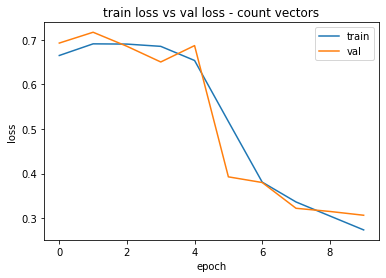

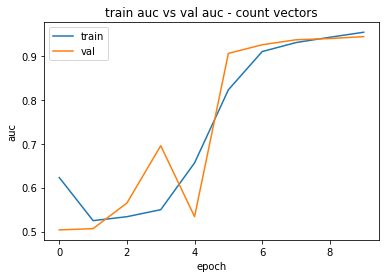

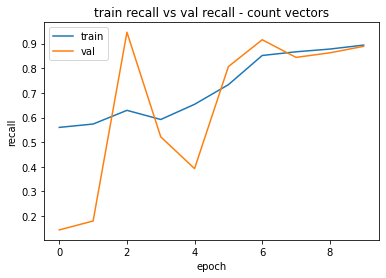

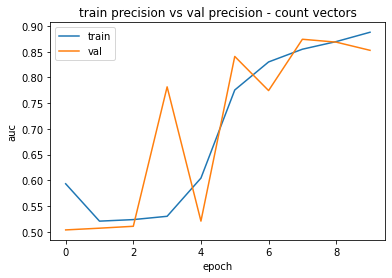

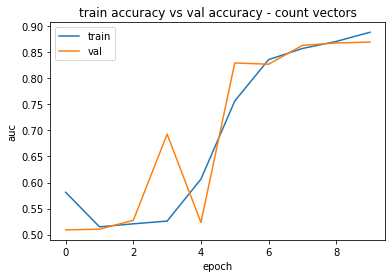

In [69]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train loss vs val loss - count vectors')
plt.legend(['train', 'val'])

plt.figure(2)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.xlabel('epoch')
plt.ylabel('auc')
plt.title('train auc vs val auc - count vectors')
plt.legend(['train', 'val'])

plt.figure(3)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xlabel('epoch')
plt.ylabel('recall')
plt.title('train recall vs val recall - count vectors')
plt.legend(['train', 'val'])

plt.figure(4)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xlabel('epoch')
plt.ylabel('auc')
plt.title('train precision vs val precision - count vectors')
plt.legend(['train', 'val'])

plt.figure(5)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('auc')
plt.title('train accuracy vs val accuracy - count vectors')
plt.legend(['train', 'val'])

plt.show()

In [70]:
# You will need to include the pickled model along with the other submission files
# The saved model will be used to verify your lstm's predictions on hidden reviews

##################################################################################
# Save your trained model as a pickle file named "lstm_classifier"               #
# You will be using this saved model to make predictions in the next module      #
##################################################################################

import pickle 

# with open('lstm_classifier', 'wb') as handle:
#     pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

pickle.dump(model, open("./sample_data/lstm_classifier.pickle", "wb"))


INFO:tensorflow:Assets written to: ram://ddabc0ef-b872-4481-9875-ae997d4eda40/assets


INFO:tensorflow:Assets written to: ram://ddabc0ef-b872-4481-9875-ae997d4eda40/assets


### Prediction (5 Points)

In [71]:
# tf.saved_model.LoadOptions(experimental_io_device = )

In [72]:
######################################################################
# Load your saved model                                              #
# Use the saved model to make predictions                            #
######################################################################

# saved_model = None

# with open('lstm_classifier', 'rb') as handle:
#     saved_model = pickle.load(handle)

saved_model = pickle.load(open("./sample_data/lstm_classifier.pickle", "rb"))

In [73]:
from nltk.util import pad_sequence
# use the saved model to predict the reviews
def predict_review(review):
  '''
  Arguments:
    review : A single review for which you want to predict the sentiment for.
             example: "This movie was amazing! I would defenitely watch it again."

  Returns:
    The predicted sentiment for the review : either 1 or 0
  '''

 ############################################################################# 
 # Predict the sentiment for the given review using the model                #
 # that you trained and return the sentiment                                 #
 #                                                                           #
 # HINT : Remember that the review needs to be "preprocessed" before you use #
 # it for prediction                                                         #
 #############################################################################

  review_cln = clean_text(review)
  review_seq = Tok.texts_to_sequences([review_cln])
  review_pad = pad_sequences(review_seq, maxlen=200, padding='post')
  review_pre = saved_model.predict(review_pad)

  if review_pre < 0.5:
    sen = 0
  else:
    sen = 1

  return sen


In [74]:
# Do not edit this cell

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = predict_review(review)
    print(f'{review[:100]} -> {p}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0


### Expected Output:

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0 <br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0